<a href="https://colab.research.google.com/github/boradj/machine-learning/blob/main/food-vision/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Important stuff

In [ ]:
##Mixed precision

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9d1fa23c-42cb-7e02-7019-c7787360244b)


##helper function

In [2]:
#helper function
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
## use tensorflow datasets
import tensorflow_datasets as tfds


In [5]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [6]:
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                    split=["train", "validation"],
                                    shuffle_files=True,
                                    as_supervised = True,
                                    with_info= True)

In [7]:
# Features of 101
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names


In [9]:
train_data
train_one_sample = train_data.take(1)

In [10]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
for image, label in train_one_sample:
  print(f"""
        Image shape:{image.shape},
        Image datatype:{image.dtype},
        Target class from Food101(tensor form):{label}
        class_name (str form):{class_names[label.numpy()]}""")


        Image shape:(512, 512, 3),
        Image datatype:<dtype: 'uint8'>,
        Target class from Food101(tensor form):30
        class_name (str form):deviled_eggs


In [12]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 28,  31,  50],
        [ 27,  30,  49],
        [ 21,  23,  44],
        ...,
        [ 17,  28,  60],
        [ 20,  30,  65],
        [ 28,  38,  73]],

       [[ 11,  14,  33],
        [ 23,  26,  45],
        [ 24,  26,  47],
        ...,
        [ 39,  50,  82],
        [ 33,  44,  76],
        [ 19,  30,  62]],

       [[ 16,  17,  37],
        [ 23,  24,  44],
        [ 19,  20,  40],
        ...,
        [ 45,  56,  86],
        [ 39,  50,  80],
        [ 36,  47,  77]],

       ...,

       [[148,  94, 117],
        [153,  99, 122],
        [153, 102, 121],
        ...,
        [ 94, 128, 166],
        [ 96, 130, 168],
        [ 96, 131, 169]],

       [[143,  89, 112],
        [151,  97, 120],
        [153, 102, 121],
        ...,
        [102, 134, 173],
        [103, 135, 174],
        [101, 135, 173]],

       [[145,  91, 114],
        [154, 100, 123],
        [158, 107, 126],
        ...,
        [105, 137, 17

In [13]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

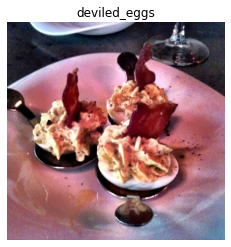

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple



In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[28 31 50]
  [27 30 49]
  [21 23 44]
  ...
  [17 28 60]
  [20 30 65]
  [28 38 73]]

 [[11 14 33]
  [23 26 45]
  [24 26 47]
  ...
  [39 50 82]
  [33 44 76]
  [19 30 62]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[21.801022 24.801022 43.80102 ]
  [17.7551   19.7551   40.755104]
  [16.16837  18.16837  41.16837 ]
  ...
  [37.61732  46.831585 75.964294]
  [30.214298 41.2143   72.02044 ]
  [26.163052 36.80591  69.877335]]

 [[22.091837 23.091837 43.09184 ]
  [10.974489 11.974489 31.97449 ]
  [16.112244 17.112244 38.112244]
  ...
  [45.48988  57.48988  81.20421 ]
  [42.413116 54.34169  80.49475 ]
  [33.551304 45.479874 71.76559 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [19]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [20]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [21]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [8]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 462 kB 68.7 MB/s 
     |████████████████████████████████| 2.9 MB 59.8 MB/s 
     |████████████████████████████████| 132 kB 72.6 MB/s 
     |████████████████████████████████| 14.8 MB 29.2 MB/s 
     |████████████████████████████████| 3.8 MB 58.7 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=c54ebc8b05f190d4980750f3633fd6fcb31e32976e889c895c6e09d321d42daa
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68724 sha256=cbd419086f21cc999e3b0495e78db74c1d59547db054e44de7525a0281741987
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built term

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [24]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [25]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

In [ ]:
history_101 = model.fit(train_data,
                        epochs=3,
                        steps_per_epoch=(len(train_data)),
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="efficientnetb0_101,"),
                                   model_checkpoint
                        ])

Saving TensorBoard log files to: training_logs/efficientnetb0_101,/20221025-100444
Epoch 1/3
   4/2368 [..............................] - ETA: 95:16:15 - loss: nan - accuracy: 0.0020    